### Modelling XShooter data with xtool ###

In [3]:
from xtool.data import XShooterData, Order
from xtool.model import OrderModel, GenericBackground, MoffatTrace, VirtualPixelWavelength

from scipy import sparse
from scipy import optimize

#### Reading XShooter data ####

In [4]:
xd = XShooterData('xtool_ds/')

In [5]:
current_order = xd[17]

#### Generating a virtual pixel table for "Wavelength"-pixels ####

In [6]:
virt_pix = VirtualPixelWavelength.from_order(current_order)
pixel_table = virt_pix()

#### Initializing the two Models ####

In [7]:
background_mdl = GenericBackground(pixel_table)
trace_mdl = MoffatTrace(pixel_table)

In [8]:
order_model = OrderModel([background_mdl, trace_mdl])

#### Show fittable parameters ####

In [9]:
order_model

<OrderModel(background_level=[  4.65477892e+18   4.65477936e+18   4.65477892e+18 ...,   4.65419002e+18
   4.65419002e+18   4.65419002e+18], amplitude=[ nan  nan  nan ...,  nan  nan  nan], trace_pos=0.0, sigma=1.0, beta=1.5 [f])>

#### Change fittable parameters ####

In [10]:
order_model.trace_pos

Parameter('trace_pos', value=0.0)

In [11]:
order_model.trace_pos = 10.

In [12]:
order_model.trace_pos

Parameter('trace_pos', value=10.0)

#### Generating a model ####

1. We generate a design matrix (https://en.wikipedia.org/wiki/Design_matrix)
2. We solve the design matrix

The evaluate does both of these steps at the same time

In [13]:
# Generating the design matrix often depicted as capital A

A = order_model.generate_design_matrix(trace_pos=-5, sigma=1.5)

# adding the uncertainties to the design matrix
A.data /= current_order.uncertainty.compressed()[A.row]

# making a vector of the result pixels often depicted as lower-case b

b = current_order.data.compressed() / current_order.uncertainty.compressed()
result = sparse.linalg.lsmr(A, b)

In [14]:
result

(array([-139.75576407,  803.07479466,  734.99747033, ...,   36.2185333 ,
         139.07635082,  118.40347293]),
 2,
 1292,
 3229.9116167401157,
 0.078203559417645799,
 24.225493274011736,
 32.189878788183037,
 272679.62519832124)

In [18]:
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix

#from http://stackoverflow.com/questions/22961541/python-matplotlib-plot-sparse-matrix-pattern

def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    fig = plt.figure()
    ax = fig.add_subplot(111, axisbg='white')
    ax.plot(m.col, m.row, 's', color='black', ms=1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('auto')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('auto')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

<IPython.core.display.Javascript object>


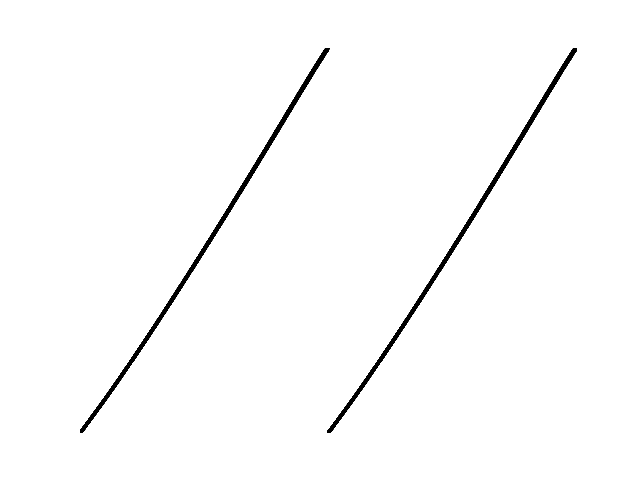

In [19]:
%matplotlib nbagg

plot_coo_matrix(A)